# Recording

In [5]:
import pyaudio
import wave
 
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 96000
CHUNK = 1024
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "file.wav"

dev_index = 6

# find SDR-Widget
def find_device():
    p = pyaudio.PyAudio()
    info = p.get_host_api_info_by_index(0)
    numdevices = info.get('deviceCount')
    devnumber=-1
    for i in range(0, numdevices):
        if (p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))
            if (p.get_device_info_by_host_api_device_index(0, i).get('name').find('Yoyodyne')==0):
                devnumber=i
    p.terminate()
    return (devnumber)

#dev_index = find_device()
dev_index = 6
print('SDR Widget:', dev_index)

audio = pyaudio.PyAudio()
 
# start Recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK,
                input_device_index = dev_index)
print ("recording...")
frames = []
 
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
print ("finished recording")
 
 
# stop Recording
stream.stop_stream()
stream.close()
audio.terminate()
 
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()

SDR Widget: 6
recording...
finished recording


## List of sound devices

In [4]:
def find_device():
    p = pyaudio.PyAudio()
    info = p.get_host_api_info_by_index(0)
    numdevices = info.get('deviceCount')
    devnumber=-1
    for i in range(0, numdevices):
        if (p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))
            if (p.get_device_info_by_host_api_device_index(0, i).get('name').find('Yoyodyne')==0):
                devnumber=i
    p.terminate()
    return (devnumber)

print('SDR Widget:',find_device())

Input Device id  0  -  HDA Intel PCH: ALC3246 Analog (hw:0,0)
Input Device id  6  -  Yoyodyne SDR-Widget: USB Audio (hw:1,0)
Input Device id  7  -  WD15 Dock: USB Audio (hw:2,0)
Input Device id  9  -  sysdefault
Input Device id  15  -  samplerate
Input Device id  16  -  speexrate
Input Device id  17  -  pulse
Input Device id  18  -  upmix
Input Device id  19  -  vdownmix
Input Device id  21  -  default
SDR Widget: 6


# Noise detect

In [ ]:
import pyaudio
import math
import struct
import wave
import time
import os

Threshold = 200

SHORT_NORMALIZE = (1.0/32768.0)
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 96000
swidth = 2

TIMEOUT_LENGTH = 5 # in seconds

f_name_directory = r'.'

class Recorder:

    @staticmethod
    def rms(frame):
        count = len(frame) / swidth
        format = "%dh" % (count)
        shorts = struct.unpack(format, frame)

        sum_squares = 0.0
        for sample in shorts:
            n = sample * SHORT_NORMALIZE
            sum_squares += n * n
        rms = math.pow(sum_squares / count, 0.5)

        return rms * 1000

    def __init__(self):
        self.dev_index = -1
        self.p = pyaudio.PyAudio()
        self.info = self.p.get_host_api_info_by_index(0)
        self.numdevices = self.info.get('deviceCount')
        for i in range(0, self.numdevices):
            if (self.p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
                print("Input Device id ", i, " - ", self.p.get_device_info_by_host_api_device_index(0, i).get('name'))
                if (self.p.get_device_info_by_host_api_device_index(0, i).get('name').find('Yoyodyne')==0):
                    self.dev_index = i
        print('SDR Widget:', self.dev_index)
        self.stream = self.p.open(format=FORMAT,
                                  channels=CHANNELS,
                                  rate=RATE,
                                  input=True,
                                  frames_per_buffer=CHUNK,
                                  input_device_index = self.dev_index)

    def record(self):
        print('Noise detected, recording beginning')
        rec = []
        current = time.time()
        end = time.time() + TIMEOUT_LENGTH

        while current <= end:

            data = self.stream.read(CHUNK)
            if self.rms(data) >= Threshold: end = time.time() + TIMEOUT_LENGTH

            current = time.time()
            rec.append(data)
        self.write(b''.join(rec))

    def write(self, recording):
        #n_files = len(os.listdir(f_name_directory))
        n_files = str(time.time()).split('.')[0]
        
        filename = os.path.join(f_name_directory, '{}.wav'.format(n_files))

        wf = wave.open(filename, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(self.p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(recording)
        wf.close()
        print('Written to file: {}'.format(filename))
        print('Returning to listening')



    def listen(self):
        print('Listening beginning')
        while True:
            input = self.stream.read(CHUNK)
            rms_val = self.rms(input)
            if rms_val > Threshold:
                self.record()

                
    def close(self):
        self.stream.close()
                
while (True):
    try:
        a = Recorder()

        a.listen()
    except:
        a.close()
        pass


Input Device id  0  -  HDA Intel PCH: ALC3246 Analog (hw:0,0)
Input Device id  6  -  Yoyodyne SDR-Widget: USB Audio (hw:1,0)
Input Device id  7  -  WD15 Dock: USB Audio (hw:2,0)
Input Device id  9  -  sysdefault
Input Device id  15  -  samplerate
Input Device id  16  -  speexrate
Input Device id  17  -  pulse
Input Device id  18  -  upmix
Input Device id  19  -  vdownmix
Input Device id  21  -  default
SDR Widget: 6
Listening beginning
Noise detected, recording beginning
Written to file: ./1608580668.wav
Returning to listening


In [9]:
import socket
import pyaudio

# Socket
HOST = socket.gethostname()
PORT = 3701

# Audio
p = pyaudio.PyAudio()
CHUNK = 1024 * 4
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 96000
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                output=True,
                frames_per_buffer=CHUNK)

with socket.socket() as server_socket:
    server_socket.connect((HOST, PORT))
    #server_socket.listen(1)
    #conn, address = server_socket.accept()
    #print("Connection from " + address[0] + ":" + str(address[1]))

    data = server_socket.recv(4096)
    for n in range(4):
        try:
            data = server_socket.recv(4096)
            stream.write(data)
        except socket.error:
            print("Client Disconnected")
            break

stream.stop_stream()
stream.close()
p.terminate()


In [2]:
import socket

HOST = 'localhost'  # The server's hostname or IP address
PORT = 3701        # The port used by the server

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((HOST, PORT))
    s.sendall(b'Hello, world')
    data = s.recv(1024)

#print('Received', data)
res = ''
for b in data:
    res += "%02x" % b

for ch in range(0,len(res),16):    
    for i in range(8):
        print(res[ch+i],end='')
    print(' ',end='')
    for i in range(8):
        print(res[ch+i+8],end='')
    print()
#print(res)

f618ea3e 010082b7
ca7fec3e 0180a338
169bee3e 01001a38
4af6f03e 0100b8b6
0ef5f13e 02004c37
16a7f33e 02006837
c658f53e 01800ab8
6292f73e 0200d2b7
d64afa3e 0100b8b7
e2b9fc3e 02006cb7
ca31ff3e 01801d38
5b7e003f 01001637
5392013f 02005e37
9168023f 02805a38
71ef033f 02004836
5197043f 01009db7
81d7053f 0200c036
bbe1063f 01001938
1bda073f 0200c0b4
0bf5083f 01008c37
5bc7093f 01808e38
b1be0a3f 0200d237
dfe60b3f 02007837
7b6c0d3f 0200cab7
cf570e3f 02005036
01970f3f 0200c034
1164103f 0100a1b7
4508113f 01003637
cfc3113f 0140b338
7308133f 01002338
bfe7133f 0200c037
c179153f 0200ccb7
47f7163f 01802438
45f0173f 02004738
715f183f 020064b7
c5a9193f 018013b8
af961a3f 01009836
851c1b3f 01003d38
cd251c3f 0100ac37
7f4a1d3f 020056b7
27941e3f 01008a37
f5711f3f 010008b6
0d66203f 01002cb7
f7be213f 0100ac38
0ddb223f 0200c737
adab233f 028060b8
75ee233f 0200fcb6
d5de243f 01800038
01f3253f 0200d0b7
4dc3263f 010015b8
a906273f 02007a37
5f70283f 0200c737
8b86293f 01c0b038
f70c2a3f 0200fb37
01a22a3f 01800838
1f7c2b3f 0

RMS 0.5553742545427003


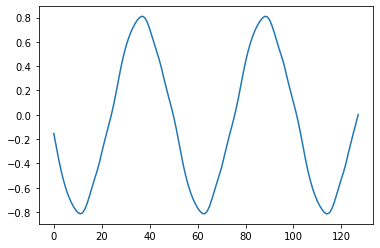

In [83]:
import socket
import numpy as np
import matplotlib.pyplot as plt
import struct
import scipy.io.wavfile as scipy_io_wavfile

HOST = 'localhost'  # The server's hostname or IP address
PORT = 3701        # The port used by the server

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((HOST, PORT))

    flag = False
    while True:
        data = s.recv(1024)

        voice = []

        for i in range(0,len(data),8):
            ampl =  struct.unpack('<f', data[i:i+4])
            voice.append(ampl[0])
            if (ampl[0] > 0.1):
                flag = True

        if flag:
            flag=False
            break

npvoice = np.array(voice)
plt.plot(npvoice)
print('RMS', np.sqrt(np.mean(npvoice**2)))
scipy_io_wavfile.write("../sw/data/ble.wav",96000,npvoice)

In [65]:
#songwav=np.column_stack((ampl,ampl)).astype('float32')

ble = np.array(voice)
import scipy.io.wavfile as scipy_io_wavfile
scipy_io_wavfile.write("../sw/data/ble.wav",96000,ble)


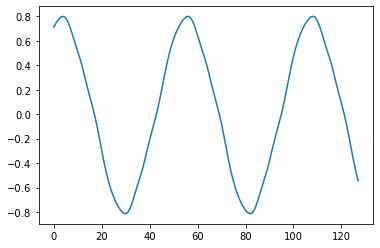

In [39]:
import socket
import numpy as np
import matplotlib.pyplot as plt
import struct

HOST = 'localhost'  # The server's hostname or IP address
PORT = 3701        # The port used by the server

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((HOST, PORT))

    flag = False
    while True:
        data = s.recv(1024)

        voice = []

        for i in range(0,len(data),8):
            ampl =  struct.unpack('<f', data[i:i+4])
            voice.append(ampl[0])
            #if (ampl[0]>1):
            flag = True

        if flag:
            plt.plot(voice)
            flag=False
            break



In [52]:
ampl

(0.45488160848617554,)